In [13]:
import numpy as np
from scipy.stats import norm

def sample_normal_mixture(n_samples, normal_params, weights):
  """
  Samples from a mixture of multiple normal distributions.

  Args:
    n_samples: Number of samples to generate.
    normal_params: A list of tuples, where each tuple contains the location and scale parameters for a normal distribution.
    weights: A list of weights for each distribution.

  Returns:
    A numpy array of sampled values.
  """

  # Generate samples from each distribution
  normal_samples = np.array([norm.rvs(loc=loc, scale=scale, size=n_samples) for loc, scale in normal_params]).T

  # Combine samples and weights
  weights = np.array(weights)

  # Normalize weights
  weights = weights / np.sum(weights)

  # Sample from the mixture distribution
  indices = np.random.choice(np.arange(len(normal_samples[0])), size=n_samples, p=weights)
  sampled_values = normal_samples[np.arange(n_samples), indices]

  return sampled_values


In [22]:
import numpy as np
from scipy.stats import norm

def density_mixture_normal(x, normal_params, weights, noise_std):
    """
    Calculates the density function of a mixture of multiple Normal distributions.

    Args:
        x: A numpy array of points where the density function should be evaluated.
        normal_params: A list of tuples, where each tuple contains the location and scale parameters for a Normal distribution.
        weights: A list of weights for each distribution.
        noise_std: The standard deviation of the noise distribution.

    Returns:
        A numpy array containing the density values for each point in x.
    """

    # Initialize the density function
    density = np.zeros_like(x)

    # Iterate over each distribution and add its contribution to the density
    idx = 0
    for loc, scale in normal_params:
        density += weights[idx] * norm.pdf(x, loc=loc, scale=np.sqrt(scale**2 + noise_std**2))
        idx += 1

    return density


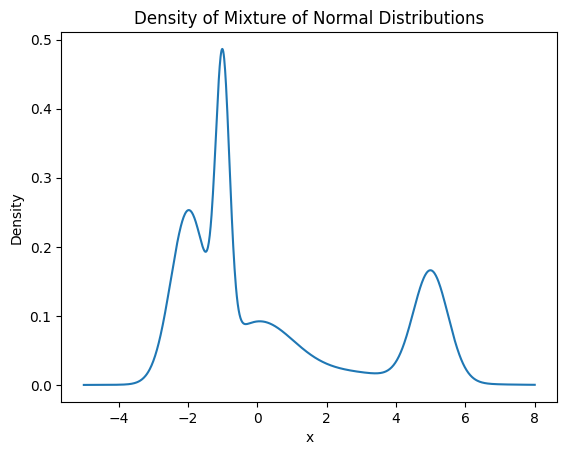

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
normal_params = [(-2, 0.5), (-1, 0.2), (0, 1), (2, 2), (5, 0.5)]
weights = [0.3, 0.2, 0.2, 0.1, 0.2]

# Generate data
x_min, x_max = -5, 8
density_x = np.linspace(x_min, x_max, 1000)
density = density_mixture_normal(density_x, normal_params, weights, noise_std=0)

# Plot the density
plt.plot(density_x, density)
plt.xlabel("x")
plt.ylabel("Density")
plt.title("Density of Mixture of Normal Distributions")
plt.show()



0.435926210047729 7.521958727021706


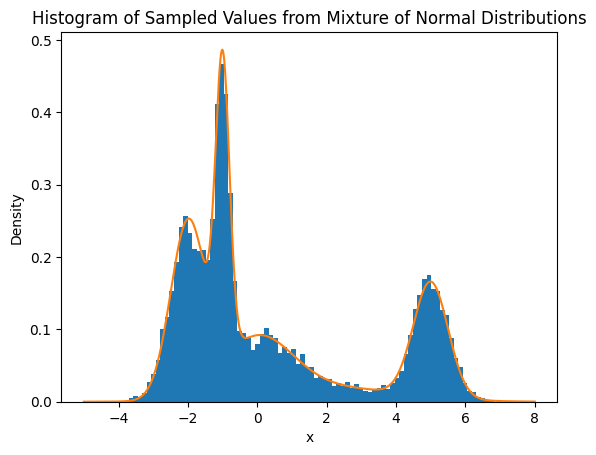

In [41]:
# Sample 10000 values from the mixture distribution
num_samples = 10000
samples = sample_normal_mixture(num_samples, normal_params, weights)

mean_est = np.mean(samples)
var_est= np.mean(np.power(samples, 2)) - np.power(mean_est, 2)
print(mean_est, var_est)

# Plot the histogram
plt.hist(samples, bins=100, range=(x_min, x_max), density=True)
plt.plot(density_x, density)
plt.xlabel("x")
plt.ylabel("Density")
plt.title("Histogram of Sampled Values from Mixture of Normal Distributions")
plt.show()


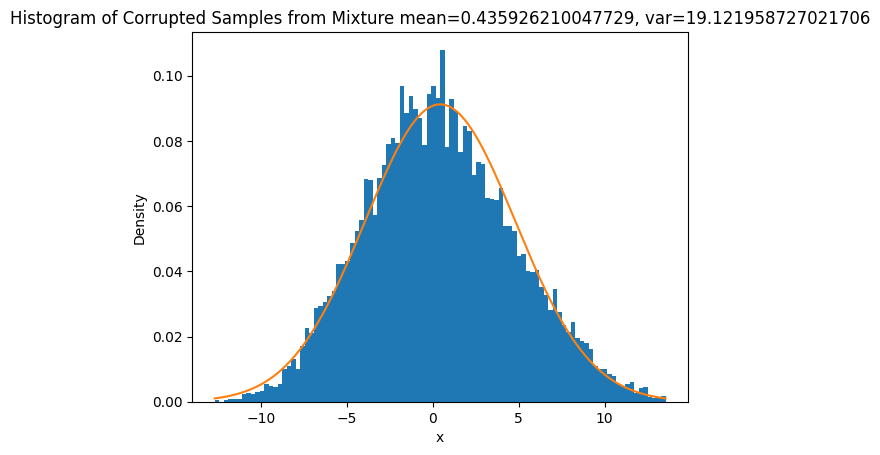

In [42]:
import numpy as np
from time import sleep
from IPython.display import clear_output


# Define the number of samples and the number of corruption steps.
num_samples = 10000
num_corruption_steps = 30000
std = 0.02

# Initialize the corrupted samples as a copy of the original samples.
corrupted_samples = np.zeros((num_samples, num_corruption_steps+1))
corrupted_samples[:, 0] = samples

# Iterate over the corruption steps.
for i in range(num_corruption_steps):
    # Generate Gaussian noise with mean 0 and variance=std**2
    noise = np.random.normal(loc=0, scale=std, size=num_samples)

    # Add the noise to the corrupted samples.
    corrupted_samples[:, i+1] = corrupted_samples[:, i] + noise
    if i % 1000  == 0:


        # Plot the histogram of the corrupted samples.
        tmp_var = var_est + i * (std**2)
        x_tmp_min = mean_est - 3 * np.sqrt(tmp_var)
        x_tmp_max = mean_est + 3 * np.sqrt(tmp_var)
        plt.hist(corrupted_samples[:, i+1], bins=100, range=(x_tmp_min, x_tmp_max), density=True)

        # plot density
        density_x = np.linspace(x_tmp_min, x_tmp_max, 1000)
        density_val = norm.pdf(density_x, loc=mean_est, scale=np.sqrt(tmp_var))
        clear_output()
        plt.plot(density_x, density_val)
        plt.xlabel("x")
        plt.ylabel("Density")

        plt.title(f"Histogram of Corrupted Samples from Mixture mean={mean_est}, var={tmp_var}")
        plt.plot
        plt.show()


In [43]:
import numpy as np
from scipy.stats import norm

def deriv_density_mixture_normal(x, normal_params, weights, noise_std):
    """
    Calculates the derivative of density function of a mixture of multiple Normal distributions.

    Args:
        x: A numpy array of points where the density function should be evaluated.
        normal_params: A list of tuples, where each tuple contains the location and scale parameters for a Normal distribution.
        weights: A list of weights for each distribution.

    Returns:
        A numpy array containing the density values for each point in x.
    """

    # Initialize the density function
    deriv_density = np.zeros_like(x)

    # Iterate over each distribution and add its contribution to the density
    idx = 0
    for loc, scale in normal_params:
        deriv_density += weights[idx] * np.multiply(norm.pdf(x, loc=loc, scale=np.sqrt(scale**2+noise_std**2)), (-(x-loc) / (scale**2+noise_std**2)))
        idx += 1

    return deriv_density


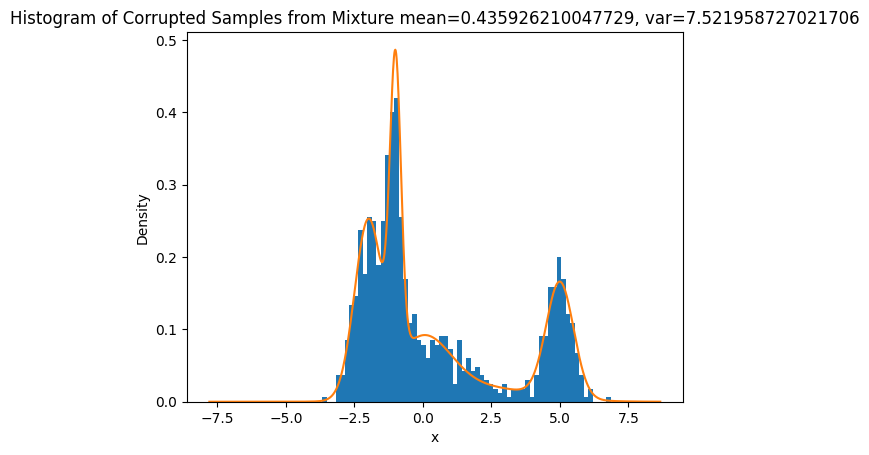

In [47]:
import numpy as np
from time import sleep
from IPython.display import clear_output


# Define the number of samples and the number of corruption steps.
num_samples = 1000
num_corruption_steps = 30000

# Initialize the corrupted samples as a copy of the original samples.
corrupted_samples = np.zeros((num_samples, num_corruption_steps+1))
final_std = np.sqrt(var_est + num_corruption_steps*(std**2))
corrupted_samples[:, num_corruption_steps] = norm.rvs(loc=mean_est, scale=final_std, size=num_samples)

# Iterate over the corruption steps.
for i in range(num_corruption_steps, 0, -1):
    # Generate Gaussian noise with mean 0 and variance=std**2
    noise = np.random.normal(loc=0, scale=std, size=num_samples)

    # Add the noise to the corrupted samples.
    noise_std = np.sqrt(i) * std
    denominator = density_mixture_normal(corrupted_samples[:, i], normal_params, weights, noise_std)
    numerator = deriv_density_mixture_normal(corrupted_samples[:, i], normal_params, weights, noise_std)
    corrupted_samples[:, i-1] = corrupted_samples[:, i] + (std**2) * np.divide(numerator, denominator)+ noise
    if i % 1000 == 0 or i == 1:
        # Plot the histogram of the corrupted samples.
        x_tmp_min = mean_est - 3 * np.sqrt(var_est)
        x_tmp_max = mean_est + 3 * np.sqrt(var_est)
        plt.hist(corrupted_samples[:, i], bins=100, range=(x_tmp_min, x_tmp_max), density=True)

        # plot density
        density_x = np.linspace(x_tmp_min, x_tmp_max, 1000)
        density_val = density_mixture_normal(density_x, normal_params, weights, noise_std=0)
        clear_output()
        plt.plot(density_x, density_val)
        plt.xlabel("x")
        plt.ylabel("Density")

        plt.title(f"Histogram of Corrupted Samples from Mixture mean={mean_est}, var={var_est}")
        plt.plot
        plt.show()